#EJERCICIO N°3 DE LA GUÍA DE AUTOENCODERS - CARLOS DOFFINY S-V
###Red Neuronal Autoencoder usando el data set **Mnist**

####Este data set consta de 60000 imágenes de entrenamiento y 10000 de prueba de 10 clases

##Imports

In [1]:
import tensorflow as tf #Para el aprendizaje automático y entrenamiento de las redes
import numpy as np #Para los diferentes vectores y matrices que se usarán
import matplotlib.pyplot as plt #Para graficar

from tensorflow.keras.models import Model, Sequential #Para la construcción de los modelos
from tensorflow.keras.layers import Dense #Para la caja negra, que será llenada con capas densas
from tensorflow.keras import Input #Para el input de los modelos
from tensorflow.keras.utils import plot_model #Para mostrar el resumen de la arquitectura en bloques
from keras.datasets import mnist #Data set a utilizar
from keras.callbacks import ModelCheckpoint #Para los checkpoints
from keras import regularizers #Regularizers
from keras import backend as K 
from keras.utils import np_utils #Utils de numpy con Keras
import keras
import gzip
%matplotlib inline
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization


##Validemos que estemos usando la GPU Tesla K80
####Ya que así se aumenta la capacidad de computo y por ende también la velocidad de procesamiento de la red

In [2]:
!nvidia-smi

Sat May 14 23:31:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Obtención y descarga del data set MNIST 
####Para el autoencoder solo se necesitarán las imágenes, mientras que para la clasificación si hacen falta los labels

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data() #Descargando el data set, y separando los datos

11501568/11490434 [==============================] - 0s 0us/step


##Dimensión de los grupos de datos

In [4]:
#Mostramos la dimensión de los grupos de datos expresados en:
# (Número de registros, pixeles de largo, pixeles de ancho)
print('Dimensión de la las imágenes de entrenamiento: ',x_train.shape)
print('\nDimensión de la los labels de entrenamiento: ',y_train.shape)
print('\nDimensión de las imágenes de validación: ',x_test.shape)
print('\nDimensión de los labels de validación: ',y_test.shape)

Dimensión de la las imágenes de entrenamiento:  (60000, 28, 28)

Dimensión de la los labels de entrenamiento:  (60000,)

Dimensión de las imágenes de validación:  (10000, 28, 28)

Dimensión de los labels de validación:  (10000,)


###Mostramos las primeras 25 imágenes del data set para verificar que su lectura haya sido correcta

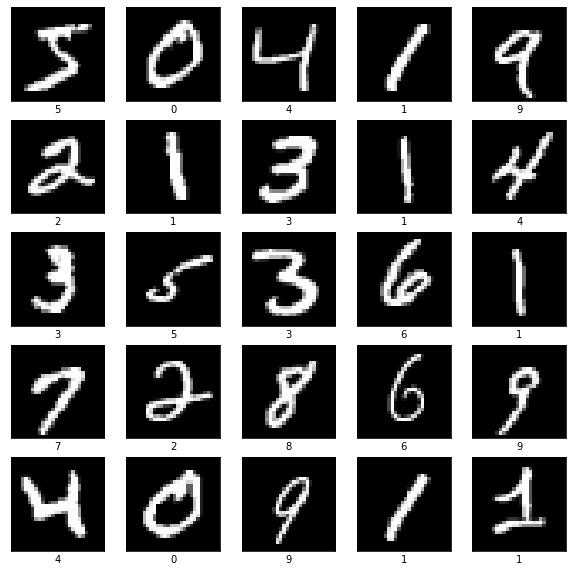

In [5]:
class_names = ['0','1','2','3','4','5','6','7','8','9'] #Definición de las clases, las cuales pueden ser encontradas en el link del data set

plt.figure(figsize=(10,10)) #Dimensión de cada una de las imágenes
for i in range(25):
    plt.subplot(5,5,i+1) #Como se van a imprimir todas en el mismo plot, necesitamos construir subplots
    plt.xticks([]) #Eliminando las referencias de escalas en el eje de las abscisas 
    plt.yticks([]) #Eliminando las referencias de escalas en el eje de las ordenadas
    plt.grid(False) #Para no mostrar el grid de las gráficas
    plt.imshow(x_train[i],'gray') #Mostrar la imágen
    plt.xlabel(class_names[y_train[i]]) #Mostrar el título de la imágen en el eje de las abscisas
plt.show() #Imprimir el plot completo

##Normalizar Data
####Con valores entre 0 y 1, y solo para la data de entrada

In [6]:
x_train = x_train / 255 #Normalizando data de entrenamiento
x_test = x_test / 255 #Normalizando data de validación

####Se impreme la primera imágen para verificar que todo sigue bien con la data recién normalizada

Text(0.5, 0, '5')

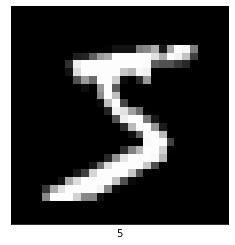

In [7]:
plt.xticks([]) #Eliminando las referencias de escalas en el eje de las abscisas 
plt.yticks([]) #Eliminando las referencias de escalas en el eje de las ordenadas
plt.grid(False) #Para no mostrar el grid de las gráficas
plt.imshow(x_train[0],'gray') #Mostrar la primera imágen con el data set recién normalizado
plt.xlabel(class_names[y_train[0]]) #Mostrar el título de la imágen en el eje de las abscisas

##Reshape de las imágenes
###Ya que los autoencoders solo aceptan vectores de entrada en sus redes densas, no matrices

In [8]:
x_train = x_train.reshape(60000,28*28) #Como las redes densas solo permiten datos en forma de vectores, y no matrices, hay que convertir la matriz en vector
x_test = x_test.reshape(10000,28*28)

print('Dimensión de la las imágenes de entrenamiento: ',x_train.shape) #Nueva dimensión de la data de entrenamiento
print('\nDimensión de la las imágenes de validación: ',x_test.shape) #Nueva dimensión de la data de validación

Dimensión de la las imágenes de entrenamiento:  (60000, 784)

Dimensión de la las imágenes de validación:  (10000, 784)


##One hot encoding
####Esto solo se hace con la data de salida (Labels)

In [9]:
#No es conveniente que el target sea un vector unidimensional, lo recomendado es que como tenemos 10 clases o tipos de valores diferentes,
# entonces se haga una matriz de 10 columnas (el num de las clases), y en donde el valor almacenado será 0 en cada una de ellas, menos en
# la clase a la cual pertenezca la data de entrada en esa fila, que tendrá en su caso un 1. Esto es lo que se conoce como vector 
#one hot-encoding. Esto hace que el target sea esta nueva matriz, y no el vector unidimensional de antes.

y_train2 = np_utils.to_categorical(y_train) #Matriz de one hot-encoding de los datos de entrenamiento
y_test2 = np_utils.to_categorical(y_test) #Matriz de one hot-encoding de los datos de validación

print('La nueva dimensión del target de entrenamiento es: ',y_train2.shape)
print('\nLa nueva dimensión del target de validación es: ',y_test2.shape)

La nueva dimensión del target de entrenamiento es:  (60000, 10)

La nueva dimensión del target de validación es:  (10000, 10)


In [10]:
print(y_train) #ANTES

[5 0 4 ... 5 6 8]


In [11]:
print(y_train2) #AHORA

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


##Dimensión de entrada y número de clases

In [12]:
input_dim = x_train.shape[1:] #Dimensión de entrada (cantidad de características de la data entrante, es decir, variables de entrada)

num_class = y_train2.shape[1] #Número de clases (cantidad de neuronas de salidas) o clases a clasificar


print('Dimensión de entrada:', input_dim)
print('Número de clases:', num_class)

Dimensión de entrada: (784,)
Número de clases: 10


#Arquitecturas
Serán 3 autoencoders apilados, que luego formarán el modelo de clasificación

##Autoencoder #1

In [13]:
 #Haremos ahora un autoencoder de 3 capas de encoder y 3 de decoder
input_img = Input(shape=(784)) #Encoded1
encoded1 = Dense(256, activation= 'relu')(input_img) #Encoded2
encoded1 = Dense(128, activation= 'relu')(encoded1) #Encoded3

encoded1 = Dense(64, activation= 'relu')(encoded1)#Latent layer

decoded1 = Dense(128, activation= 'relu')(encoded1) #Decoded1
decoded1 = Dense(256, activation= 'relu')(decoded1) #Decoded2
decoded1 = Dense(784, activation= 'sigmoid')(decoded1) #Decoded3

###Guardamos la capa latente, para luego usarla en la clasificación

In [14]:
encoder1 = Model(input_img,encoded1) #Modelo que va desde el encoder, a la data latente. Es el que comprime la data

###Configuraciones finales

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 784)               2014

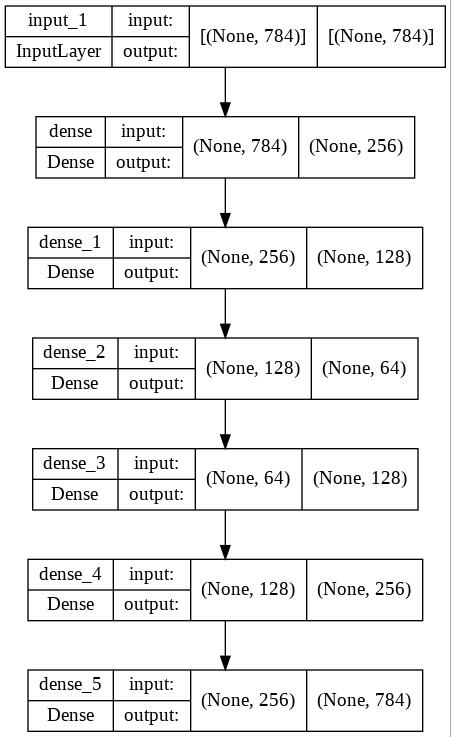

In [15]:
autoencoder1 = Model(input_img,decoded1) #Modelo completo del autoencoder, con su (entrada, salida)
autoencoder1.compile(optimizer = 'adam', loss='binary_crossentropy') #Compilamos el modelo con su optimizador y su pérdida. La función de pérdida será la entropía binaria de ese modelo.

autoencoder1.summary() #Resumen del modelo tipo tabla
plot_model(autoencoder1, to_file='autoencoder.jpg', show_shapes=True) #Resumen del modelo tipo plot en imágen

###Resumen del encoder, cuya última capa es la latente que necesitamos

In [16]:
encoder1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
Total params: 242,112
Trainable params: 242,112
Non-trainable params: 0
_________________________________________________________________


###Obtenemos la capa latente del modelo

In [17]:
latent_layer1 = encoder1.layers[-1]

###Entrenando el primer modelo y sus neuronas

In [18]:
history1 = autoencoder1.fit(x_train,x_train, validation_data=(x_test,x_test), epochs=150, batch_size=256, shuffle=True) #Entrenando la red.
#Recordemos que la data de entrada y el target es el mismo

Epoch 1/150
235/235 [==============================] - 6s 5ms/step - loss: 0.2171 - val_loss: 0.1392
Epoch 2/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1242 - val_loss: 0.1133
Epoch 3/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1084 - val_loss: 0.1029
Epoch 4/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1012 - val_loss: 0.0972
Epoch 5/150
235/235 [==============================] - 2s 6ms/step - loss: 0.0964 - val_loss: 0.0938
Epoch 6/150
235/235 [==============================] - 2s 7ms/step - loss: 0.0930 - val_loss: 0.0909
Epoch 7/150
235/235 [==============================] - 2s 8ms/step - loss: 0.0904 - val_loss: 0.0887
Epoch 8/150
235/235 [==============================] - 1s 5ms/step - loss: 0.0884 - val_loss: 0.0866
Epoch 9/150
235/235 [==============================] - 1s 4ms/step - loss: 0.0868 - val_loss: 0.0852
Epoch 10/150
235/235 [==============================] - 1s 4ms/step - loss: 0.0852 - val_lo

###Guardamos el modelo

In [19]:
autoencoder1.save_weights('autoencoder1.h5')

##Autoencoder #2

In [20]:
 #Haremos ahora un autoencoder de 3 capas de encoder y 3 de decoder
input_img = Input(shape=(784)) #Encoded1
encoded2 = Dense(128, activation= 'relu')(input_img) #Encoded2
encoded2 = Dense(64, activation= 'relu')(encoded2) #Encoded3

encoded2 = Dense(32, activation= 'relu')(encoded2)#Latent layer

decoded2 = Dense(64, activation= 'relu')(encoded2) #Decoded1
decoded2 = Dense(128, activation= 'relu')(decoded2) #Decoded2
decoded2 = Dense(784, activation= 'sigmoid')(decoded2) #Decoded3

###Guardamos la capa latente, para luego usarla en la clasificación

In [21]:
encoder2 = Model(input_img,encoded2) #Modelo que va desde el encoder, a la data latente. Es el que comprime la data

###Configuraciones finales

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 784)               1011

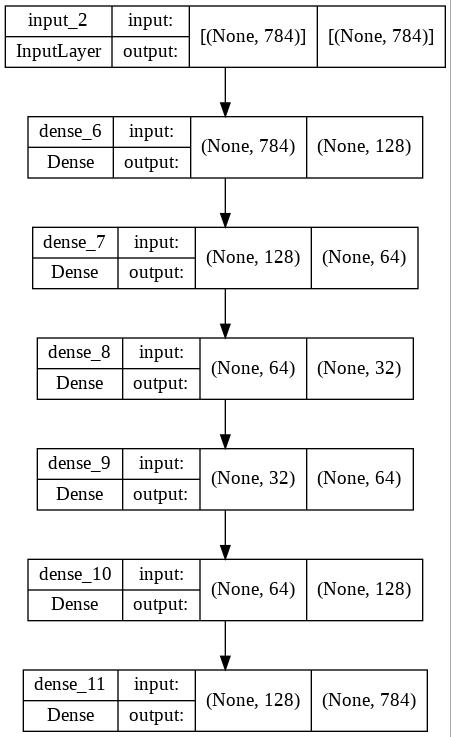

In [22]:
autoencoder2 = Model(input_img,decoded2) #Modelo completo del autoencoder, con su (entrada, salida)
autoencoder2.compile(optimizer = 'adam', loss='binary_crossentropy') #Compilamos el modelo con su optimizador y su pérdida. La función de pérdida será la entropía binaria de ese modelo.

autoencoder2.summary() #Resumen del modelo tipo tabla
plot_model(autoencoder2, to_file='autoencoder.jpg', show_shapes=True) #Resumen del modelo tipo plot en imágen

###Resumen del encoder, cuya última capa es la latente que necesitamos

In [23]:
encoder2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


###Obtenemos la capa latente del modelo

In [24]:
latent_layer2 = encoder2.layers[-1]

###Entrenando el segundo modelo y sus neuronas

In [25]:
history2 = autoencoder2.fit(x_train,x_train, validation_data=(x_test,x_test), epochs=150, batch_size=256, shuffle=True) #Entrenando la red.
#Recordemos que la data de entrada y el target es el mismo

Epoch 1/150
235/235 [==============================] - 2s 6ms/step - loss: 0.2415 - val_loss: 0.1661
Epoch 2/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1490 - val_loss: 0.1376
Epoch 3/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1292 - val_loss: 0.1225
Epoch 4/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1215 - val_loss: 0.1174
Epoch 5/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1165 - val_loss: 0.1124
Epoch 6/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1119 - val_loss: 0.1087
Epoch 7/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1090 - val_loss: 0.1069
Epoch 8/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1069 - val_loss: 0.1048
Epoch 9/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1049 - val_loss: 0.1030
Epoch 10/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1030 - val_lo

###Guardamos el modelo

In [26]:
autoencoder2.save_weights('autoencoder2.h5')

##Autoencoder #3

In [27]:
 #Haremos ahora un autoencoder de 3 capas de encoder y 3 de decoder
input_img = Input(shape=(784)) #Encoded1
encoded3 = Dense(64, activation= 'relu')(input_img) #Encoded2
encoded3 = Dense(32, activation= 'relu')(encoded3) #Encoded3

encoded3 = Dense(16, activation= 'relu')(encoded3)#Latent layer

decoded3 = Dense(32, activation= 'relu')(encoded3) #Decoded1
decoded3 = Dense(64, activation= 'relu')(decoded3) #Decoded2
decoded3 = Dense(784, activation= 'sigmoid')(decoded3) #Decoded3

###Guardamos la capa latente, para luego usarla en la clasificación

In [28]:
encoder3 = Model(input_img,encoded3) #Modelo que va desde el encoder, a la data latente. Es el que comprime la data

###Configuraciones finales

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 784)               5096

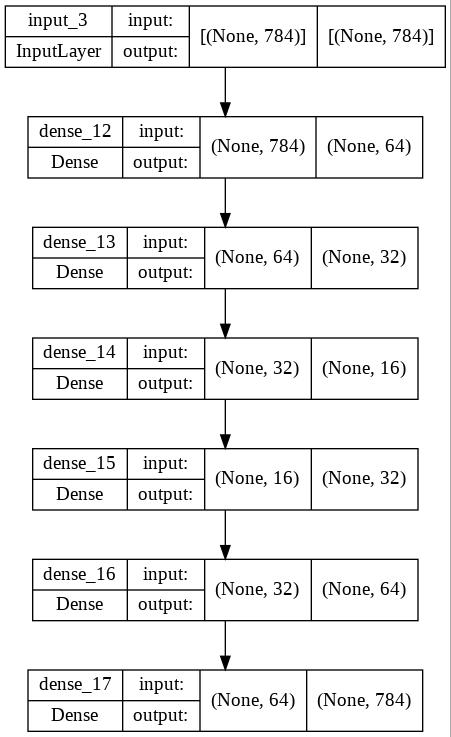

In [29]:
autoencoder3 = Model(input_img,decoded3) #Modelo completo del autoencoder, con su (entrada, salida)
autoencoder3.compile(optimizer = 'adam', loss='binary_crossentropy') #Compilamos el modelo con su optimizador y su pérdida. La función de pérdida será la entropía binaria de ese modelo.

autoencoder3.summary() #Resumen del modelo tipo tabla
plot_model(autoencoder3, to_file='autoencoder.jpg', show_shapes=True) #Resumen del modelo tipo plot en imágen

###Resumen del encoder, cuya última capa es la latente que necesitamos

In [30]:
encoder3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
Total params: 52,848
Trainable params: 52,848
Non-trainable params: 0
_________________________________________________________________


###Obtenemos la capa latente del modelo

In [31]:
latent_layer3 = encoder3.layers[-1]

###Entrenando el tercer modelo y sus neuronas

In [32]:
history3 = autoencoder3.fit(x_train,x_train, validation_data=(x_test,x_test), epochs=150, batch_size=256, shuffle=True) #Entrenando la red.
#Recordemos que la data de entrada y el target es el mismo

Epoch 1/150
235/235 [==============================] - 2s 5ms/step - loss: 0.2805 - val_loss: 0.2088
Epoch 2/150
235/235 [==============================] - 1s 5ms/step - loss: 0.1885 - val_loss: 0.1729
Epoch 3/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1655 - val_loss: 0.1561
Epoch 4/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1538 - val_loss: 0.1493
Epoch 5/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1483 - val_loss: 0.1447
Epoch 6/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1443 - val_loss: 0.1406
Epoch 7/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1402 - val_loss: 0.1370
Epoch 8/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1361 - val_loss: 0.1330
Epoch 9/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1334 - val_loss: 0.1310
Epoch 10/150
235/235 [==============================] - 1s 4ms/step - loss: 0.1315 - val_lo

In [33]:
print(x_test.shape)
print(y_test2.shape)

(10000, 784)
(10000, 10)


###Guardamos el modelo

In [34]:
autoencoder3.save_weights('autoencoder3.h5')

In [35]:
print(input_dim)

(784,)


##Modelo clasificador

In [36]:
def classifier(latent_layer1,latent_layer2,latent_layer3):
  model = Sequential() #Creando la caja negra con arquitectura secuencial

  model.add(Flatten(input_shape=(28, 28)))
  model.add(Dense(128, activation='relu'))
  model.add(latent_layer1)
  model.add(latent_layer2)
  model.add(latent_layer3)
  model.add(Dense(num_class, activation = 'softmax'))

  model.summary() #Resumen del modelo

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy']) #Como es un problema probabilístico, se usa un error categorical
  # El optimizador que mejor funciona es el adam, y también usaremos métricas


  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 10)                170       
                                                                 
Total params: 111,514
Trainable params: 111,514
Non-trai

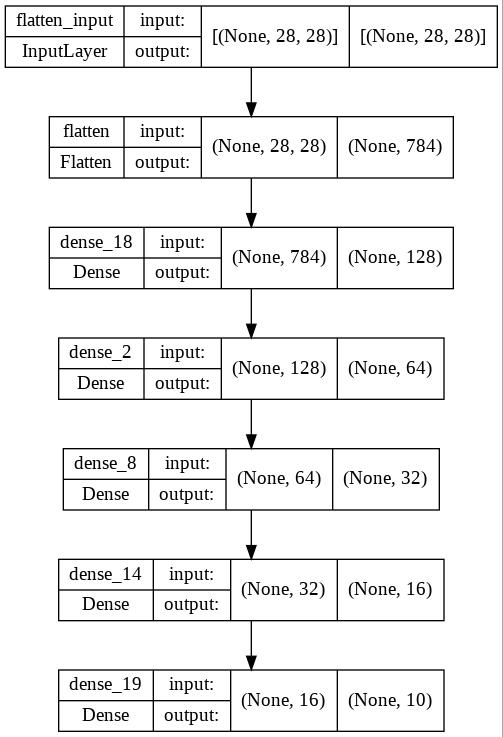

In [37]:
model = classifier(latent_layer1,latent_layer2,latent_layer3)

plot_model(model, to_file='model.jpg', show_shapes=True) #Para mostrar el resumen de la arquitectura

###Reshape de la data de entrenamiento

In [38]:
x_train = x_train.reshape(60000,28,28) #Los autoencoders necesitan vectores unidimensionales, pero el clasificador si puede usar matrices

In [39]:
print('Dimensión de la las imágenes de entrenamiento: ',x_train.shape)
print('\nDimensión de la los labels de entrenamiento: ',y_train2.shape)

Dimensión de la las imágenes de entrenamiento:  (60000, 28, 28)

Dimensión de la los labels de entrenamiento:  (60000, 10)


###Reshape de la data de validación

In [40]:
x_test = x_test.reshape(10000,28,28)#Los autoencoders necesitan vectores unidimensionales, pero el clasificador si puede usar matrices

In [41]:
print('\nDimensión de las imágenes de validación: ',x_test.shape)
print('\nDimensión de los labels de validación: ',y_test2.shape)


Dimensión de las imágenes de validación:  (10000, 28, 28)

Dimensión de los labels de validación:  (10000, 10)


###Entrenando el modelo de clasificación

In [42]:
history = model.fit(x_train,y_train2, validation_data=(x_test,y_test2), epochs=50, batch_size=256, shuffle=True)
#El shuffle es para que la data se revuelva y no la entrene siempre en el mismo orden, mejorando la calidad del aprendizaje
#Mientras el accuracy más cerca a 1 mejor

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.5696 - accuracy: 0.8277 - val_loss: 0.2289 - val_accuracy: 0.9334
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1879 - accuracy: 0.9461 - val_loss: 0.1507 - val_accuracy: 0.9548
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1281 - accuracy: 0.9627 - val_loss: 0.1202 - val_accuracy: 0.9657
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9714 - val_loss: 0.1069 - val_accuracy: 0.9691
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0775 - accuracy: 0.9768 - val_loss: 0.1003 - val_accuracy: 0.9714
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0604 - accuracy: 0.9821 - val_loss: 0.1140 - val_accuracy: 0.9664
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0520 - accuracy: 0.9842 - val_loss: 0.1006 - val_accuracy: 0.9710
Epoch 

In [43]:
tf.config.run_functions_eagerly(True) #Config del run de tensorflow, para evitar posibles errores

##Evaluación del modelo final
Se calculan sus valores de pérdida y de acierto con la data de validación

In [44]:
score = model.evaluate(x_test, y_test2, verbose=0) #Para mostrar la pérdida

print('\nValor de la pérdida:',score[0]) #Imprimiendo el valor de la pérdida
print('\nScore del accuracy:',score[1]) #Imprimiendo el valor del accuracy

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "



Valor de la pérdida: 0.13160601258277893

Score del accuracy: 0.98089998960495


##Graficar Pérdida

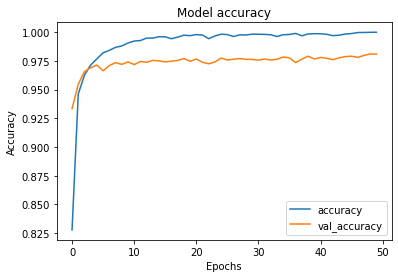

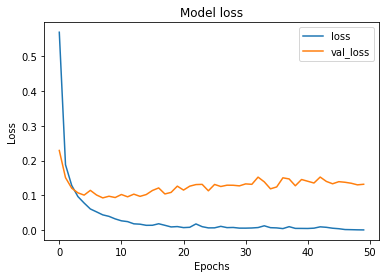

In [45]:
plt.figure() #Gráfica del accuracy del modelo
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right') #Podemos decirle dónde queremos colocar la leyenda
plt.show()

plt.figure() #Gráfica de la pérdida del modelo
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()

##Model Predict

In [46]:
predictions = model.predict(x_test) #Predicción del modelo final

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


###Obtenemos las predicciones de la primera imágen en cada clase

In [47]:
predictions[0] #Predicciones resultantes de una imágen en específico

array([1.0964086e-17, 2.9042438e-16, 5.1708041e-15, 1.8676351e-13,
       1.5462429e-17, 6.0097797e-23, 5.1726904e-18, 1.0000000e+00,
       4.8520371e-16, 6.2104503e-14], dtype=float32)

Se selecciona la clase con el mayor valor, como la clave predicha

In [48]:
np.argmax(predictions[0]) #Imprimiendo la clase con el mayor valor en la predicción

7

Y ahora se compara con el valor real de la clase de esa imágen

In [49]:
y_test[0] #Clase real a la cual pertenece

7

##Función para graficar las clases y su % de predicción para cada imágen
Esto se hará con un gráfico de barra, en donde en el eje x estarán las clases, mientras que en el eje y estarán los % de predicción

In [50]:
def plot_image(i, predictions_array, true_label, img): #Para mostrar la imágen
  predictions_array, true_label, img = predictions_array, true_label[i], img[i] #Guardamos la predicción real y las del model predict
  plt.grid(False) #Para eliminar los número de los ejes
  plt.xticks([]) #Sin numeración y rangos en el eje x
  plt.yticks([]) #Sin numeración y rangos en el eje y

  plt.imshow(img, cmap=plt.cm.binary) #Se muestra la imágen

  predicted_label = np.argmax(predictions_array) #Obteniendo el label predicho
  if predicted_label == true_label: #Si el label predicho es el mismo que el real, que se muestre el texto en azul
    color = 'blue'
  else: #Sino, en rojo
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color) #Label de cada imágen, en donde se muestra el valor de la predicción, su % y el valor real entre ()

def plot_value_array(i, predictions_array, true_label): #Mostrar el gráfico de barras
  predictions_array, true_label = predictions_array, true_label[i] #Guardamos la predicción real y las del model predict
  plt.grid(False) #Para eliminar los número de los ejes
  plt.xticks(range(10)) #Con numeración del 0 al 9 en el eje x
  plt.yticks([]) #Sin numeración y rangos en el eje y
  thisplot = plt.bar(range(10), predictions_array, color="#777777") #A todas las barras se les pone el color gris por defecto
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red') #Rojo a la predicha (si está mala)
  thisplot[true_label].set_color('blue') #Porque la que es real, tendrá azul

##Corroboramos la clasificación de una sola imágen

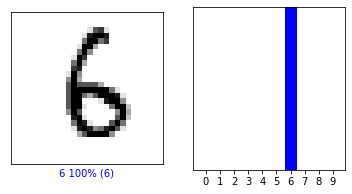

In [51]:
i = 3000 #Imágen cualquiera del data set
plt.figure(figsize=(6,3)) #Tamaño de la imágen
plt.subplot(1,2,1) #Subplot de una fila, dos columnas, empezando desde la primera posición
plot_image(i, predictions[i], y_test, x_test) #Mostrando la imágen del data set
plt.subplot(1,2,2) #Subplot de una fila, dos columnas, empezando desde la primera posición
plot_value_array(i, predictions[i],  y_test) #Mostrando la gráfica de predicción
plt.show() #Mostrar todo

##Corroboramos la clasificación de un conjunto de imágenes

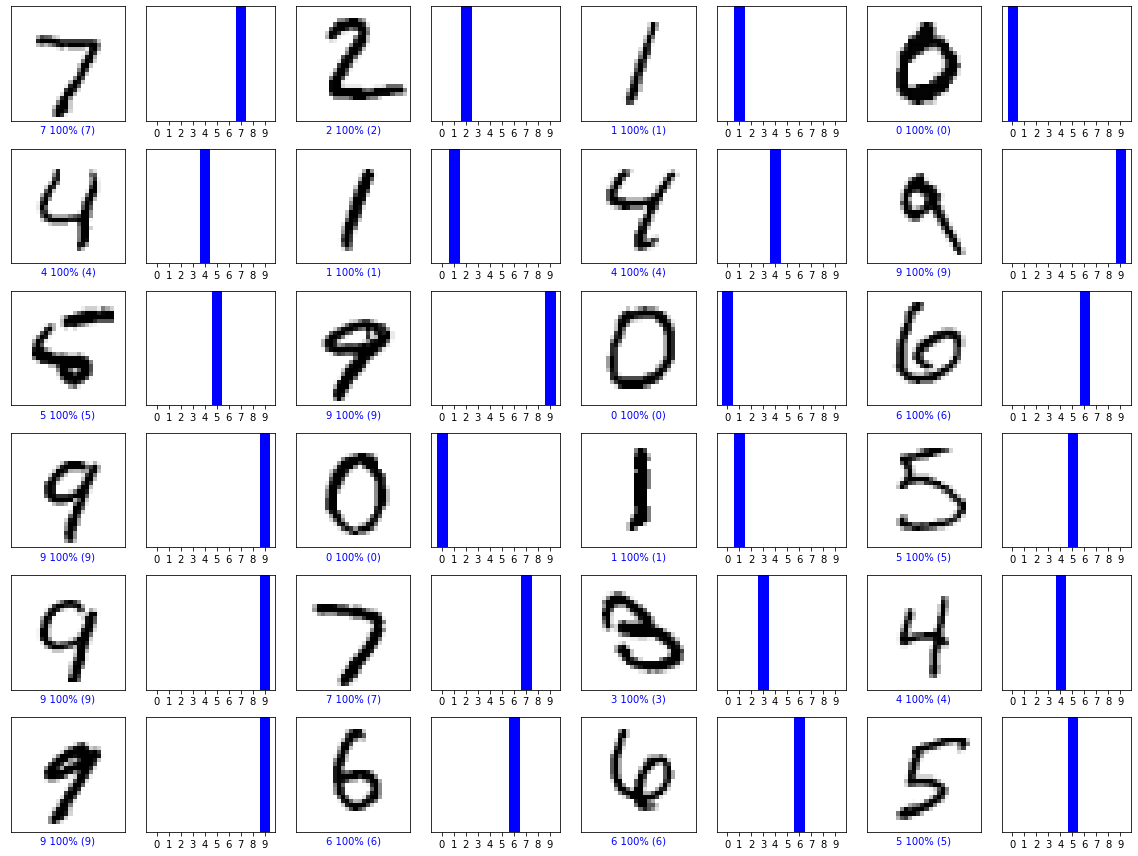

In [52]:
num_rows = 6 #Número de filas deseadas
num_cols = 4 #Número de columnas deseadas
num_images = num_rows*num_cols #Número total de imágenes
plt.figure(figsize=(2*2*num_cols, 2*num_rows)) #Tamaño de las imágenes

for i in range(num_images): #For para imprimir todo
  plt.subplot(num_rows, 2*num_cols, 2*i+1) #Subplots de (n filas, n columnas, empezando desde el 1)
  plot_image(i, predictions[i], y_test, x_test) #Imágen
  plt.subplot(num_rows, 2*num_cols, 2*i+2) #Subplots de (n filas, n columnas, empezando desde la segunda posicións)
  plot_value_array(i, predictions[i], y_test) #Gráfica
plt.tight_layout() 
plt.show() #Mostrar todo

## Confusion matrix
####Esta matriz lo que indica es la cantidad o porcentaje de clasificaciones correctas en la diagonal de la matriz, así como la cantidad de clasificaciones incorrectas en cada clase

In [53]:
print('La dimensión de la predicción de la validación es: ', predictions.shape)
#Aquí hacemos una pequeña prueba para ver si los valores y resultados de un caso en específico, concuerdan
print('\nLa salida deseada es: ',y_test[0])
print('\nLa salida de la predicción es: ', predictions[0])

La dimensión de la predicción de la validación es:  (10000, 10)

La salida deseada es:  7

La salida de la predicción es:  [1.0964086e-17 2.9042438e-16 5.1708041e-15 1.8676351e-13 1.5462429e-17
 6.0097797e-23 5.1726904e-18 1.0000000e+00 4.8520371e-16 6.2104503e-14]


In [54]:
print(np.argmax(predictions[0])) #Aquí verificamos que lo que está en la posición inicial del y_test sea igual al del outputTest

7


In [55]:
print(y_test) #Data de salida esperada para la validación

[7 2 1 ... 4 5 6]


In [56]:
outputTest = np.argmax(predictions, axis=1) #Para obtener el valor máximo de las filas
outputTest = outputTest.round() #Redondear el valor máximo obtenido
print(outputTest) #Data de salida obtenida para la validación

[7 2 1 ... 4 5 6]


In [60]:
from sklearn.metrics import confusion_matrix #Import para la matriz de confusión

cm = confusion_matrix(y_test, outputTest) #NO se pueden ingresar aquí los vectores encode, se le tiene que pasar el valor
#real. En el segundo argumento, se extraerá la posición en la cual ese vector o fila tiene su valor máximo, que es el que queremos obtener
print(cm)

[[ 972    0    0    1    1    0    2    0    3    1]
 [   0 1124    2    2    0    1    2    1    3    0]
 [   1    2 1011    2    2    1    2    5    6    0]
 [   0    0    1  993    0    2    0    4    5    5]
 [   1    1    2    0  965    0    4    3    1    5]
 [   2    0    0   10    1  872    2    1    3    1]
 [   4    2    2    1    6    6  936    1    0    0]
 [   2    1    6    2    1    0    0 1005    3    8]
 [   3    0    3    3    4    3    2    2  949    5]
 [   1    3    0    4    9    5    0    3    2  982]]


In [63]:
def plot_confusion_matrix(cm, num_classes,normalize=True,title='Matriz de Confusión',cmap=plt.cm.Blues): #Función para imprimir mejor la matriz de confusión
      
      import itertools
      
      classes = ['0', '1', '2','3','4','5','6','7','8','9']

      plt.figure(figsize = (7,7))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=90)
      plt.yticks(tick_marks, classes)
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          cm = np.round(cm,3)
      thresh = cm.max() / 1.05
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, cm[i, j],
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('Original')
      plt.xlabel('Predicciones')

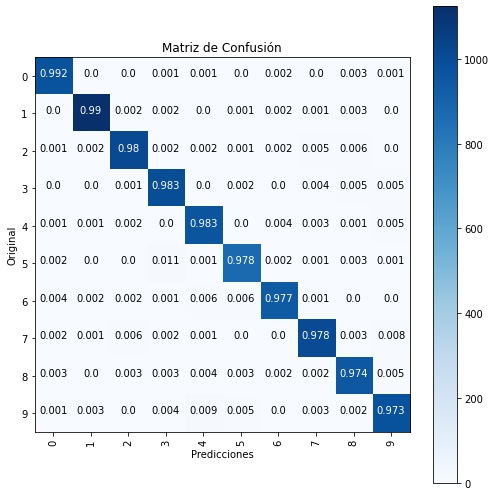

In [64]:
plot_confusion_matrix(cm, num_class) #Matriz de confusión